<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/Python_ARIMA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。  
　　　ただし、死亡数は年齢３区分ごとに、一旦死亡率を求め計算します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*  [データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データ解析を支援する機能を提供する[pandas](https://pandas.pydata.org/)や、数値計算用の[numpy](https://numpy.org/)、統計モデル作成に便利な[statsmodels](https://www.statsmodels.org/stable/index.html)や[pmdarima](https://pypi.org/project/pmdarima/)、データプロット用の[matplotlib](https://matplotlib.org/)といったライブラリを使います。

In [ ]:
# 該当ＵＲＬを変数に格納
repo = "https://raw.githubusercontent.com/u-10bei/Population_Projections/"
popURL = repo + "main/data/population_jp_year.csv"

# ライブラリの読み込み
import pandas as pd
from dateutil.relativedelta import relativedelta

# ネット上のファイル読み込み
pop_csv = pd.read_csv( popURL,
                      parse_dates = [ 'Year' ])
pop_csv.Year = pop_csv.Year.apply( lambda x: x + relativedelta( months = 9 ))
pop_df = pop_csv[[ 'Year', 'Total' ]]\
         .set_index( 'Year' )
pop_dfB = pop_csv[[ 'Year', 'Birth' ]]\
          .astype({ 'Birth': float }).set_index( 'Year' )
pop_dfDr = pop_csv[[ 'Year', 'Death' ]]\
          .astype({ 'Death': float }).set_index( 'Year' )\
          .rename(columns={ 'Death': 'Dr' })
pop_dfDr.Dr = pop_dfDr.Dr / pop_df.Total

# 手順２　データの可視化

まず、データをプロットしてみます。  

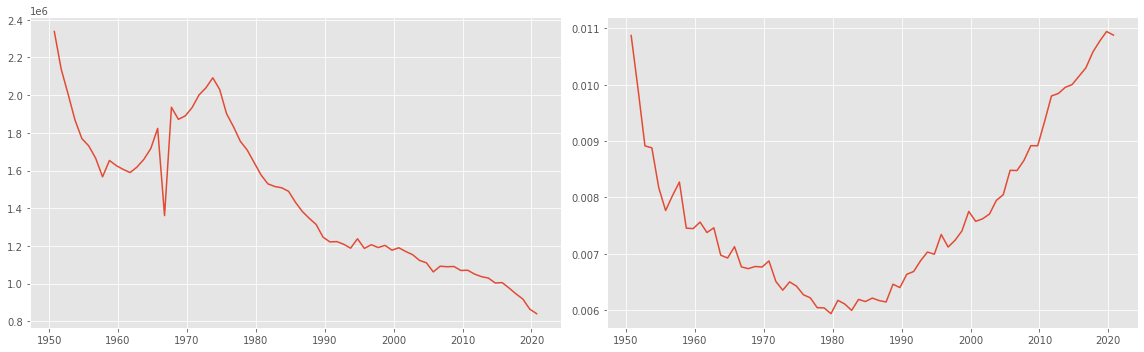

In [35]:
# ライブラリの読み込み
import matplotlib.pyplot as plt
plt.style.use( 'ggplot' )

fig = plt.figure( figsize = [ 16, 5 ])

ax1 = fig.add_subplot( 1, 2, 1 )   #１行２列の１番目
ax1.plot( pop_dfB )

ax2 = fig.add_subplot( 1, 2, 2 )   #１行２列の２番目
ax2.plot( pop_dfDr )

fig.tight_layout()
plt.show()

次に、自己相関を確認してみます。

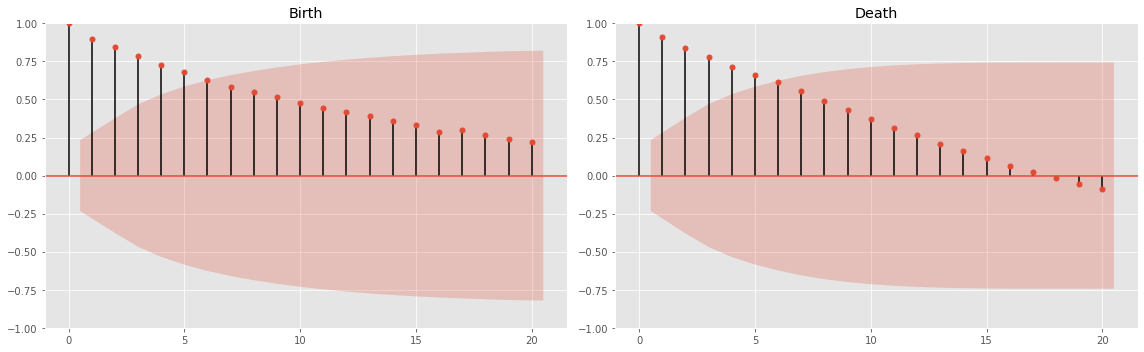

In [ ]:
# ライブラリの読み込み
import statsmodels.api as sm

fig = plt.figure( figsize = [ 16, 5 ])

ax1 = fig.add_subplot( 1, 2, 1 )   #１行２列の１番目
# 自己相関のグラフ
sm.graphics.tsa.plot_acf( pop_dfB,
                          lags = 20,
                          alpha = .05,
                          ax = ax1,
                          title = "Birth" )

ax2 = fig.add_subplot( 1, 2, 2 )   #１行２列の２番目
sm.graphics.tsa.plot_acf( pop_dfDr,
                          lags = 20,
                          alpha = .05,
                          ax = ax2,
                          title = "Death" )

fig.tight_layout()
plt.show()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


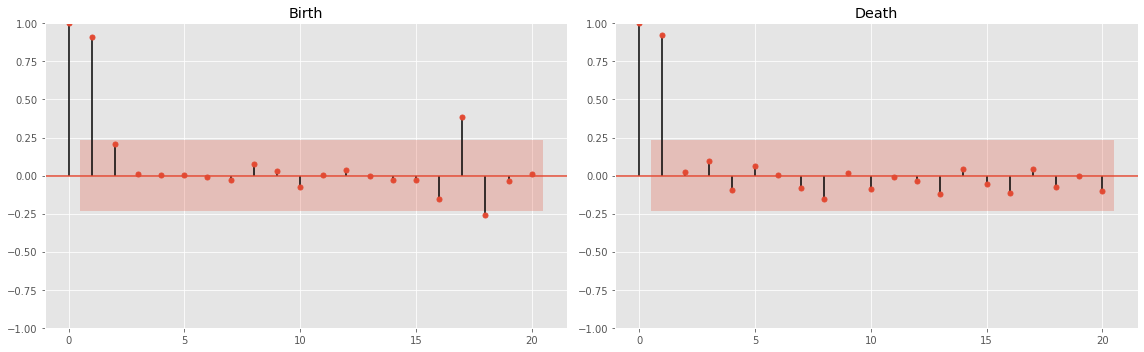

In [ ]:
fig = plt.figure( figsize = [ 16, 5 ])

ax1 = fig.add_subplot( 1, 2, 1 )   #１行２列の１番目
# 偏自己相関のグラフ
sm.graphics.tsa.plot_pacf( pop_dfB,
                           lags = 20,
                           ax = ax1,
                           title = "Birth" )

ax2 = fig.add_subplot( 1, 2, 2 )   #１行２列の２番目
sm.graphics.tsa.plot_pacf( pop_dfDr,
                           lags = 20,
                           ax = ax2,
                           title = "Death" )

fig.tight_layout()
plt.show()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
prow_test = 6
pop_test2 = pop_df.tail( prow_test )
pop_testB = pop_dfB.tail( prow_test )
pop_trainB = pop_dfB.head( prow_test * -1 )
pop_testDr = pop_dfDr.tail( prow_test )
pop_trainDr = pop_dfDr.head( prow_test * -1 )

# 手順４　ＡＲＩＭＡモデルによる予測

まず、学習データを使ってＡＲＩＭＡモデルを推定します。

In [ ]:
# ライブラリの読み込み
import pmdarima as pm

# ＡＲＩＭＡモデルの推定
pop_arimaB = pm.auto_arima( pop_trainB,
                           information_criterion = 'aic' )
pop_arimaDr = pm.auto_arima( pop_trainDr,
                           information_criterion = 'aic' )
pop_arimaB,pop_arimaDr

(ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True))

出生数では、ＡＲＩＭＡ（１，１，１）が  
死亡率では、ＡＲＩＭＡ（０，２，１）が推定されたので、モデリングと予測をしてみます。

In [ ]:
# モデリング
from statsmodels.tsa.arima.model import ARIMA
pop_arimaB = ARIMA( pop_trainB, order = ( 1, 1, 1 )).fit()
pop_arimaDr = ARIMA( pop_trainDr, order = ( 0, 2, 1 )).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  

In [ ]:
# ＡＲＩＭＡによる予測
pop_arima_fB = pop_arimaB.predict( '2015', '2020' )
pop_arima_fDr = pop_arimaDr.predict( '2015', '2020' )
pop_arima_fB,pop_arima_fDr

(2015-10-01    1.009914e+06
 2016-10-01    1.013639e+06
 2017-10-01    1.015815e+06
 2018-10-01    1.017086e+06
 2019-10-01    1.017829e+06
 2020-10-01    1.018263e+06
 Freq: AS-OCT, Name: predicted_mean, dtype: float64, 2015-10-01    0.010161
 2016-10-01    0.010316
 2017-10-01    0.010472
 2018-10-01    0.010627
 2019-10-01    0.010783
 2020-10-01    0.010938
 Freq: AS-OCT, Name: predicted_mean, dtype: float64)

# 手順５　出生数、死亡率から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [ ]:
pop_Total = pop_test2.Total +\
            pop_arima_fB -\
            (pop_test2.Total *\
             pop_arima_fDr) 
pop_arima_f3 = pop_Total.shift( 1 ).tail()

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

In [ ]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = repo + "main/data/forecast_ipss.csv"

# ネット上のファイル読み込み
ipss_csv = pd.read_csv( ipssURL,
                        parse_dates = [ 'Year' ])
ipss_csv.Year = ipss_csv.Year.apply( lambda x: x + relativedelta( months = 9 ))
ipss_test = ipss_csv.set_index( 'Year' )

# ライブラリの読み込み
import numpy as np

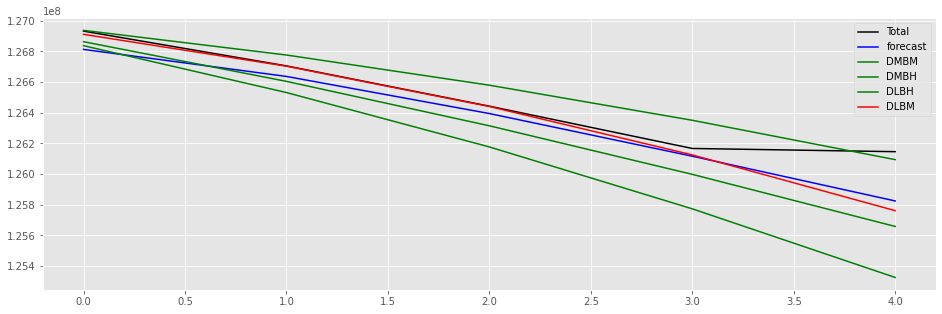

In [ ]:
plot_test2 = pop_test2.tail()
# 予測と実測の比較（グラフ）
x_axis = np.arange(pop_arima_f3.shape[0])
plt.figure( figsize = [ 16, 5 ])
plt.plot( x_axis,
          plot_test2,
          label = "Total",
          color = 'black' )
plt.plot( x_axis,
          pop_arima_f3,
          label="forecast",
          color='blue')
plt.plot( x_axis,
          ipss_test.DMBM,
          label="DMBM",
          color='green')
plt.plot( x_axis,
          ipss_test.DMBH,
          label="DMBH",
          color='green')
plt.plot( x_axis,
          ipss_test.DLBH,
          label="DLBH",
          color='green')
plt.plot( x_axis,
          ipss_test.DLBM,
          label="DLBM",
          color='red')
plt.legend()
plt.show()

実データまでは、まだ少し差があるようです。

# 次のステップ


*   同じ事をRでやってみる。　->　[Ｒ_人口推計_その３](https://colab.research.google.com/drive/1MZ2XYpcnUZ8Dg7uYU-BEqRQOPy0y7u8r?usp=sharing)
*   色んなモデルを当てはめてみる　->　こちら
*   人口３区分の死亡率を使って推計する　->　[Ｐｙｔｈｏｎ_人口推計_その４](https://colab.research.google.com/drive/1lgXdk2FnCO9Onn05Yje_xcpaJSoJQC3J?usp=sharing)
